In [ ]:
# Instalando no Google Colab biblioteca Pandera

!pip install pandera

In [14]:
# Importando bibliotecas utilizadas

import pandas as pd
import pandera as pa
import numpy as np

In [15]:
# Configurando Pandas, para exibir até 100 colunas por consulta

pd.set_option('display.max_columns', 100)

In [16]:
# Importando dataframe

df = pd.read_csv('/content/marketing_campaign.csv', sep =';', parse_dates = ['Dt_Customer'])

In [17]:
# Definindo DF para backup

dfbackup = df.copy()

## Documentação


1.   Base de dados relacionada a campanha de marketing de empresa varejista nos Estados Unidos
2.   Base de dados coletada até 2014
3.   Conforme instrução, dados deverão ser traduzidos para Português
4.   Explicação do schema (em Português):


      - ano_nasc: Ano de nascimento do cliente
      - escolaridade: Nível de escolaridade
      - estado_civil: Estado civil
      - cadastro: Data do cadastro como cliente
      - renda: Renda anual em USD
      - criancas_casa: Quantidade de criaças vivendo com cliente
      - adolescentes_casa: Quantidade de adolescentes vivendo com cliente
      - ultima_compra: Dias desde última compra
      - gasto_vinho: Gasto com vinhos em USD
      - gasto_frutas: Gasto com frutas em USD
      - gasto_carnes: Gasto com carnes em USD
      - gasto_peixes: Gasto com peixes em USD
      - gasto_doces: Gasto com doces em USD
      - gasto_gold: Gasto com produtos Gold em USD
      - compras_comdesconto: Quantidade de compras realizadas com desconto (por cliente)
      - compras_web: Quantidade de compras realizadas pela Web (por cliente)
      - compras_catalogo: Quantidade de compras realizadas por catálogo (por cliente)
      - compras_direto_loja: Quantidade de compras realizadas diretamente na loja (por cliente)
      - visitas_website: Quantidade de visitas ao website da loja (por cliente)
      - campanha_1: 1 se consumidor aceitou a oferta da primeira campanha promocional, 0 se não tiver aceitado
      - campanha_2: 1 se consumidor aceitou a oferta da segunda campanha promocional, 0 se não tiver aceitado
      - campanha_3: 1 se consumidor aceitou a oferta da terceira campanha promocional, 0 se não tiver aceitado
      - campanha_4: 1 se consumidor aceitou a oferta da quarta campanha promocional, 0 se não tiver aceitado
      - resposta_ultima_campanha: 1 se consumidor aceitou a oferta da última campanha promocional, 0 se não tiver aceitado
      - reclamacao_2anos: 1 se consumidor fez reclamação nos últimos 2 anos

Pré-visualização

In [ ]:
df.info()

Transformação tabela

In [ ]:
# Análise do campo ID, para torná-lo Index da tabela

df.groupby(['ID']).size().sort_values(ascending = False)

### INCONSISTÊNCIA ENCONTRADA: EXISTE ID = 0
### OBS: optou-se por deixar como 0, para não excluir linha (cadastro é legítimo)

In [21]:
# Tornar ID Index

df.set_index('ID', inplace = True)

In [24]:
# Drop colunas 'Z_CostContact' e 'Z_Revenue' (Apresentam valores constantes/ Não há explicação na documentação)

df.drop(['Z_CostContact', 'Z_Revenue'], axis = 1, inplace = True)

In [26]:
#Traduzindo nomes das colunas

df.rename(columns={
    'Year_Birth':'ano_nasc',
    'Education':'escolaridade',
    'Marital_Status':'estado_civil',
    'Income':'renda',
    'Kidhome':'criancas_casa',
    'Teenhome':'adolescentes_casa',
    'Dt_Customer':'cadastro',
    'Recency':'ultima_compra',
    'MntWines':'gasto_vinho',
    'MntFruits':'gasto_frutas',
    'MntMeatProducts':'gasto_carnes',
    'MntFishProducts':'gasto_peixes',
    'MntSweetProducts':'gasto_doces',
    'MntGoldProds':'gasto_gold',
    'NumDealsPurchases':'compras_comdesconto',
    'NumWebPurchases':'compras_web',
    'NumCatalogPurchases':'compras_catalogo',
    'NumStorePurchases':'compras_direto_loja',
    'NumWebVisitsMonth':'visitas_website',
    'AcceptedCmp1':'campanha_1',
    'AcceptedCmp2':'campanha_2',
    'AcceptedCmp3':'campanha_3',
    'AcceptedCmp4':'campanha_4',
    'AcceptedCmp5':'campanha_5',
    'Response':'resposta_ultima_campanha',
    'Complain':'reclamacao_2anos'
    },inplace = True)

Tradução dados colunas 'escolaridade' e 'estado_civil'

In [29]:
pd.unique(df['escolaridade'])

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [30]:
# Dados 'escolaridade'
df.replace(['Graduation'], 'Pré-Graduação', inplace = True)
df.replace(['PhD'], 'Doutorado', inplace = True)
df.replace(['Master'], 'Mestrado', inplace = True)
df.replace(['Basic'], 'Ensino Básico', inplace = True)
df.replace(['2n Cycle'], 'Segundo ciclo', inplace = True)

In [31]:
pd.unique(df['estado_civil'])

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [32]:
# Observação: por recomendação expressa da empresa (aka professor), decidiu-se não transformar os valores "YOLO" e "Alone" em "Solteiro", tampouco transformar "Absurd" em NA
# Com isso, procura-se manter a fidelidade dos dados o máximo possível
# Em uma versão anterior desse trabalho, essas alterações haviam sido feitas

df.replace(['Single'],'Solteiro/a', inplace = True)
df.replace(['Married'],'Casado/a', inplace = True)
df.replace(['Together'],'Vivendo com companheiro/a', inplace = True)
df.replace(['Divorced'],'Divorciado/a', inplace = True)
df.replace(['Widow'],'Viuvo/a', inplace = True)
df.replace(['Alone'], 'Sozinho(a)', inplace = True)
df.replace(['Absurd'], 'Absurdo', inplace = True)
# Dado "YOLO" será mantido como tal (Trata-se de uma sigla em inglês que traduzida corresponderia a "Só se vive uma vez")

Validação dos dados da tabela (utilizando biblioteca Pandera)

In [37]:
schema = pa.DataFrameSchema(
    columns = {
       'ano_nasc': pa.Column(pa.Int),
       'escolaridade': pa.Column(pa.String),
       'estado_civil': pa.Column(pa.String, nullable = True),
       'renda': pa.Column(pa.Float, nullable = True),
       'criancas_casa': pa.Column(pa.Int),
       'adolescentes_casa': pa.Column(pa.Int),
       'cadastro': pa.Column(pa.DateTime),
       'ultima_compra': pa.Column(pa.Int),
       'gasto_vinho': pa.Column(pa.Int),
       'gasto_frutas': pa.Column(pa.Int),
       'gasto_carnes': pa.Column(pa.Int),
       'gasto_peixes': pa.Column(pa.Int),
       'gasto_doces': pa.Column(pa.Int),
       'gasto_gold': pa.Column(pa.Int),
       'compras_comdesconto': pa.Column(pa.Int),
       'compras_web': pa.Column(pa.Int),
       'compras_catalogo': pa.Column(pa.Int),
       'compras_direto_loja': pa.Column(pa.Int),
       'visitas_website': pa.Column(pa.Int),
       'campanha_1': pa.Column(pa.Int),
       'campanha_2': pa.Column(pa.Int),
       'campanha_3': pa.Column(pa.Int),
       'campanha_4': pa.Column(pa.Int),
       'resposta_ultima_campanha': pa.Column(pa.Int),
       'reclamacao_2anos': pa.Column(pa.Int),
    }
)

In [ ]:
schema.validate(df)

# Inconsistências encontradas:
# estado_civil <NA> : IDs 7734, 4369
# renda NaN: 24 IDs

Tratamento (análise de valores)

In [ ]:
df.info()

In [ ]:
pd.unique(df['campanha_1']) #OK

In [ ]:
pd.unique(df['campanha_2']) #OK

In [ ]:
pd.unique(df['campanha_3']) #OK

In [ ]:
pd.unique(df['campanha_4']) #OK

In [ ]:
pd.unique(df['ano_nasc'])

# Dados duvidosos: 1900/ 1899/ 1893
# Observação: por recomendação expressa da empresa (aka professor), decidiu-se deletar os registros que continham esses anos de nascimento, para evitar eventuais problemas na análise dos dados
# Em uma versão anterior do trabalho optou-se por tornar os valores NaN

In [ ]:
df.loc[df.ano_nasc == 1900] # ID 7829

In [ ]:
df.loc[df.ano_nasc == 1899] # ID 1150

In [ ]:
df.loc[df.ano_nasc == 1893] # ID 11004

In [65]:
df.drop([7829, 1150, 11004], axis = 0, inplace = True)

In [ ]:
pd.unique(df['criancas_casa']) #OK

In [ ]:
pd.unique(df['adolescentes_casa']) #OK

In [ ]:
pd.unique(df['renda'])

In [ ]:
df.groupby(['renda']).size().sort_values(ascending = True)

In [ ]:
pd.unique(df['ultima_compra']) #OK

In [ ]:
pd.unique(df['gasto_vinho'])

# Observação: questionou-se a equipe se seria possível gastar 1 ou 2 USD com vinho, e ela afirmou que sim.

In [ ]:
pd.unique(df['gasto_frutas']) #OK

In [ ]:
pd.unique(df['gasto_carnes']) #OK

In [ ]:
pd.unique(df['gasto_peixes'])

# Observação: questionou-se a equipe se seria possível gastar 1 ou 2 USD com peixes, e ela afirmou que sim.

In [ ]:
pd.unique(df['gasto_doces']) #OK

In [ ]:
pd.unique(df['gasto_gold']) #OK

In [ ]:
pd.unique(df['compras_comdesconto']) #OK

In [ ]:
pd.unique(df['compras_web']) #OK

In [ ]:
pd.unique(df['compras_catalogo']) #OK

In [ ]:
pd.unique(df['compras_direto_loja']) #OK

In [ ]:
pd.unique(df['visitas_website']) #OK

In [ ]:
pd.unique(df['resposta_ultima_campanha']) #OK

In [ ]:
pd.unique(df['reclamacao_2anos']) #OK

Análise / Plotagem (breve)

Equipe (aka eu) possui três objetivos:

1.   Saber quantas vezes os consumidores que consomem mais vinho (gasto > 500 USD) fizeram compras pela WEB;
2.   Saber quantos consumidores menores de 21 anos compraram vinho, ferindo a legislação local;
3.   Saber se clientes que possuem menores de 18 anos (crianças e adolescentes) em casa aderiram à última campanha promocional.

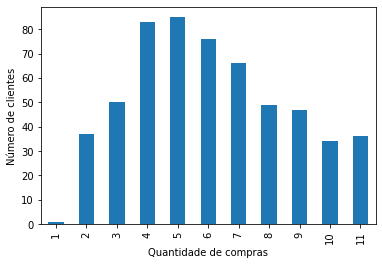

In [85]:
# Objetivo 1

filtrovinho = df.gasto_vinho > 500
dfvinho = df.loc[filtrovinho]
dfvinho.groupby(['compras_web']).size().plot.bar(xlabel = 'Quantidade de compras', ylabel = 'Número de clientes')

In [98]:
df.dtypes

ano_nasc                             int64
escolaridade                        object
estado_civil                        object
renda                              float64
criancas_casa                        int64
adolescentes_casa                    int64
cadastro                    datetime64[ns]
ultima_compra                        int64
gasto_vinho                          int64
gasto_frutas                         int64
gasto_carnes                         int64
gasto_peixes                         int64
gasto_doces                          int64
gasto_gold                           int64
compras_comdesconto                  int64
compras_web                          int64
compras_catalogo                     int64
compras_direto_loja                  int64
visitas_website                      int64
campanha_3                           int64
campanha_4                           int64
campanha_5                           int64
campanha_1                           int64
campanha_2 

In [108]:
# Objetivo 2

# Filtrar clientes menores de 18 anos em 2014 (dataset de 2014)
filtro_menores21 = df.ano_nasc > 1994
df_menores21 = df.loc[filtro_menores21]

In [ ]:
# Número de menores de 21 anos cadastrados

df_menores21.shape # Foram 7 cadastros ao todo

In [ ]:
df_menores21.groupby(['gasto_vinho']).size().sort_values()

# Desses, somente 1 não consumiu vinho (aprox. 14%)

In [ ]:
df_menores21

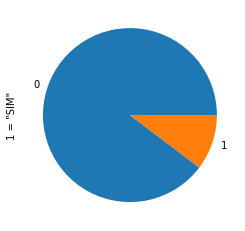

In [93]:
# Objetivo 3

fitro_criancas = df.criancas_casa >= 1
filtro_adolescentes = df.adolescentes_casa >=1

dfmenores = df.loc[fitro_criancas & filtro_adolescentes]
dfmenores.groupby(['resposta_ultima_campanha']).size().plot.pie(ylabel = '1 = "SIM"')

Validação final

In [78]:
schema = pa.DataFrameSchema(
    columns = {
       'ano_nasc': pa.Column(pa.Int),
       'escolaridade': pa.Column(pa.String),
       'estado_civil': pa.Column(pa.String, nullable = True),
       'renda': pa.Column(pa.Float, nullable = True),
       'criancas_casa': pa.Column(pa.Int),
       'adolescentes_casa': pa.Column(pa.Int),
       'cadastro': pa.Column(pa.DateTime),
       'ultima_compra': pa.Column(pa.Int),
       'gasto_vinho': pa.Column(pa.Int),
       'gasto_frutas': pa.Column(pa.Int),
       'gasto_carnes': pa.Column(pa.Int),
       'gasto_peixes': pa.Column(pa.Int),
       'gasto_doces': pa.Column(pa.Int),
       'gasto_gold': pa.Column(pa.Int),
       'compras_comdesconto': pa.Column(pa.Int),
       'compras_web': pa.Column(pa.Int),
       'compras_catalogo': pa.Column(pa.Int),
       'compras_direto_loja': pa.Column(pa.Int),
       'visitas_website': pa.Column(pa.Int),
       'campanha_1': pa.Column(pa.Int),
       'campanha_2': pa.Column(pa.Int),
       'campanha_3': pa.Column(pa.Int),
       'campanha_4': pa.Column(pa.Int),
       'resposta_ultima_campanha': pa.Column(pa.Int),
       'reclamacao_2anos': pa.Column(pa.Int),
    }
)

In [ ]:
schema.validate(df)

Exportação dos dados

In [97]:
df.to_csv('campanha_dados_tratados.csv')
#Observação: optou-se propositalmente por deixar o index = True